# **Chapter 10 – Keras人工神经网络示例**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# 10.1 感知机 Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int_)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


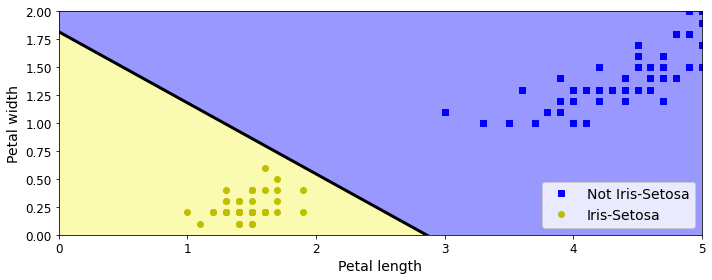

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# 激活函数

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


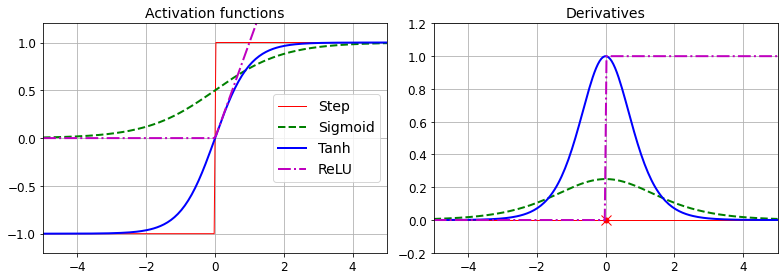

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

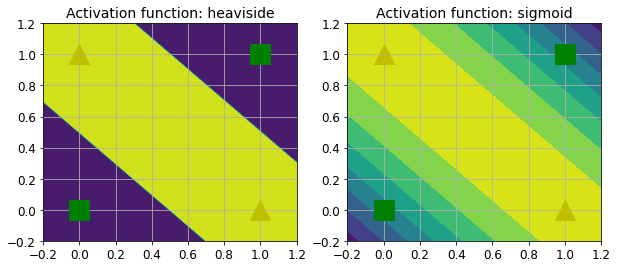

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# 10.2.2 构建图像分类器

First let's import TensorFlow and Keras.

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'2.7.0'

In [11]:
keras.__version__

'2.7.0'

# 经典的 Fashion-MNIST 数据集
Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [13]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [14]:
X_train_full.dtype

dtype('uint8')

数据集已经分为训练集和测试集，但是没有验证集，现在创建一个。

另外，由于要使用梯度下降训练神经网络，因此必须比例缩放输入特征。为了简单起见，将像素强度除以255。

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

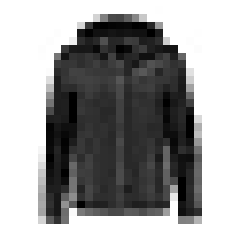

In [16]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [19]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


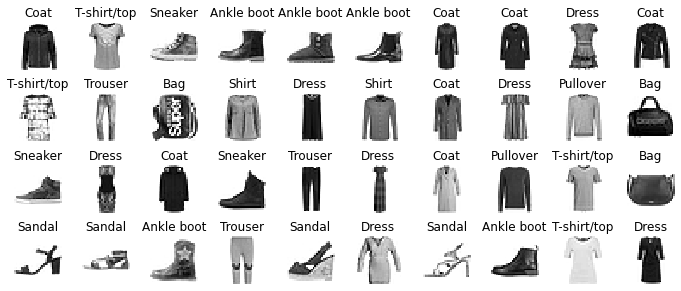

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

# **顺序式API创建模型**

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


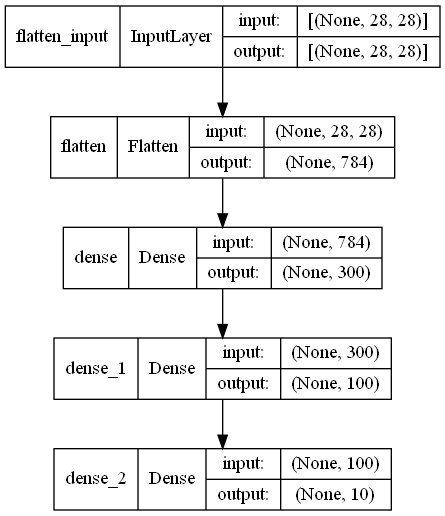

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [29]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [30]:
model.get_layer(hidden1.name) is hidden1

True

In [31]:
weights, biases = hidden1.get_weights()

In [32]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [33]:
weights.shape

(784, 300)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
biases.shape

(300,)

In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

**This is equivalent to:**

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [37]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4842 - accuracy: 0.8316 - val_loss: 0.4349 - val_accuracy: 0.8528
Epoch 3/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4391 - accuracy: 0.8456 - val_loss: 0.5281 - val_accuracy: 0.8008
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4123 - accuracy: 0.8566 - val_loss: 0.3920 - val_accuracy: 0.8646
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3939 - accuracy: 0.8619 - val_loss: 0.3746 - val_accuracy: 0.8684
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3752 - accuracy: 0.8677 - val_loss: 0.3719 - val_accuracy: 0.8722
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3632 - accuracy: 0.8715 - val_loss: 0.3612 - val_accuracy:

如果训练集非常不平衡，某些类的代表过多，而其他类的代表不足，在调用fit（）方法时设置**class_weight**参数会很有用。可以给代表性不足的类更大的权重，给代表过多的类更小的权重。Keras在计算损失时将使用这些权重。

如果你需要每个实例的权重，设置**sample_weight**参数。

如果class_weight和sample_weight都提供了，Keras会把它们相乘。

In [38]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [39]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


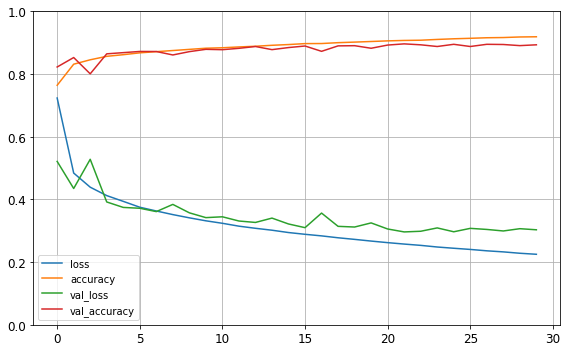

In [41]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [42]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3363 - accuracy: 0.8826


[0.3363315761089325, 0.8826000094413757]

使用模型predict（）方法对新实例进行预测。由于没有实际的新实例，因此我们将仅使用测试集的前三个实例：

In [43]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [44]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [45]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


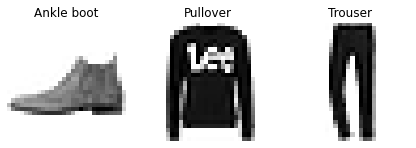

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# 10.2.3　使用顺序API构建回归MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [48]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

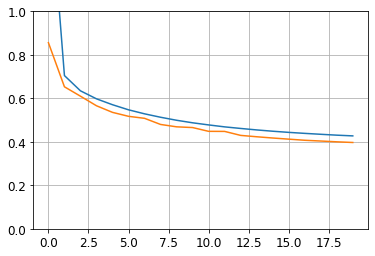

In [51]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [52]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

# 10.2.4 使用函数式API构建复杂模型

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [56]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4659 - val_loss: 0.4313

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [59]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315

Adding an auxiliary output for regularization:

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [62]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [63]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

In [64]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 2ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# 子类化API模型

In [65]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [66]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

# 10.2.6 保存和还原模型

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [69]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


In [70]:
model.save("my_keras_model.h5")

In [71]:
model = keras.models.load_model("my_keras_model.h5")

In [72]:
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [73]:
model.save_weights("my_keras_weights.ckpt")

In [74]:
model.load_weights("my_keras_weights.ckpt")

# 10.2.7 回调函数

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

fit（）方法接受一个callbacks参数，该参数使你可以指定Keras在训练开始和结束时，每个轮次的开始和结束时（甚至在处理每个批量之前和之后）将调用的对象列表。例如，在训练期间ModelCheckpoint回调会定期保存模型的检查点。

此外，如果在训练期间使用验证集，则可以在创建ModelCheckpoint时设置save_best_only=True。在这种情况下，只有在验证集上的模型性能达到目前最好时，它才会保存模型。这样，你就不必担心训练时间太长而过拟合训练集：只需还原训练后保存的最后一个模型，这就是验证集中的最佳模型。以下代码是实现提前停止的简单方法（见第4章）：

In [77]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - ETA: 0s - loss: 0.501 - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3976 - val_lo

如果需要额外的控制，则可以轻松编写自己的自定义回调。作为如何执行的示例，以下自定义回调将显示训练过程中验证损失与训练损失之间的比率（例如，检测过拟合）：

In [79]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

如你所料，你可以实现on train be__gin（）、on_train_end（）、on_epoch_begin（）、on e_poch_end（）、on_batch_begin（）和on_batch_end（）。如果需要的话，在评估和预测期间也可以使用回调（例如用于调试）。为了进行评估，你应该实现on_test_begin（）、on_test_end（）、on_test_batch_begin（）或on test__batch end_（）（由evaluate（）调用），为了进行预测，你应该实现on_predict_begin（）、on_pre dict_end（）、on_predict_batch_begin（）或on_predict_batch_end（）（由predict（）调用）。

In [80]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

345/363 [===========================>..] - ETA: 0s - loss: 0.3275
val/train: 1.08
363/363 [==============================] - 1s 1ms/step - loss: 0.3302 - val_loss: 0.3559


# 10.2.8 使用TensorBoard可视化

In [81]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [82]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_12_26-22_23_59'

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [85]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 3ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [87]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2021_12_26-22_24_36'

In [88]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [90]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 3s 6ms/step - loss: 0.5530 - val_loss: 302.8466
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 63.6669 - val_loss: 0.9735
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.9411 - val_loss: 0.9599
Epoch 4/30
363/363 [==============================] - 1s 3ms/step - loss: 0.9197 - val_loss: 0.8464
Epoch 5/30
363/363 [==============================] - 1s 3ms/step - loss: 0.9819 - val_loss: 0.9281
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.9240 - val_loss: 0.9089
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.9179 - val_loss: 0.8815
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8950 - val_loss: 0.9007
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.9150 - val_loss: 0.8734
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.8921 - val_loss: 0.8

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [91]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# 10.3 微调神经网络超参数

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [94]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

E:\PycharmProjects\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [95]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4060 - val_l

In [96]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3412


In [97]:
y_pred = keras_reg.predict(X_new)

In [98]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon. In the meantime, I've added `.tolist()` and `.rvs(1000).tolist()` as workarounds.

In [99]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [========

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D05C807548>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112...
                                                          0.00502142573

In [100]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [101]:
rnd_search_cv.best_score_

-0.31833014885584515

In [102]:
rnd_search_cv.best_estimator_

In [103]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3029


-0.30288204550743103

In [104]:
model = rnd_search_cv.best_estimator_.model
model

In [105]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3029


0.30288204550743103

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*在MNIST数据集上训练一个深度MLP，你可以使用keras.datasets.mnist.load_data（）加载它，看是否可以获得98％以上的精度。请尝试使用本章介绍的方法来寻找最佳学习率（即通过成倍地提高学习率，画出误差，并找出误差发生的点）。尝试一下其他的功能——保存检查点，使用早期停止，并使用TensorBoard绘制学习曲线。*

Let's load the dataset:

In [106]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [107]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [108]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [109]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

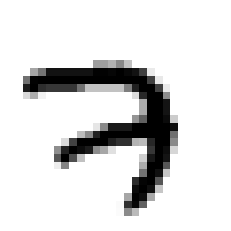

In [110]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [111]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [112]:
X_valid.shape

(5000, 28, 28)

In [113]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

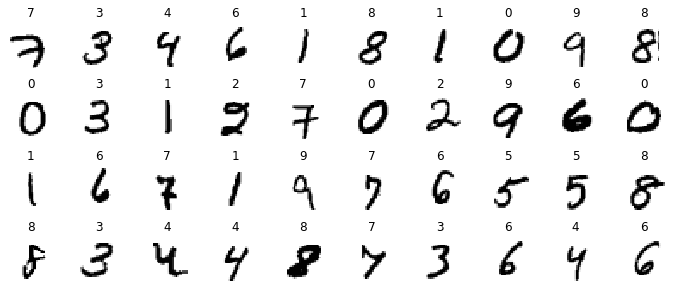

In [114]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [115]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [116]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [118]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [119]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 8s 5ms/step - loss: 5175061388354684784465674240.0000 - accuracy: 0.5927 - val_loss: 2.3911 - val_accuracy: 0.1126


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

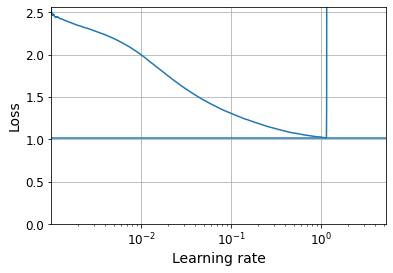

In [120]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [121]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [122]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [123]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [124]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [125]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2363 - accuracy: 0.9263 - val_loss: 0.0975 - val_accuracy: 0.9712
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0943 - accuracy: 0.9708 - val_loss: 0.0995 - val_accuracy: 0.9712
Epoch 3/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0670 - accuracy: 0.9787 - val_loss: 0.0761 - val_accuracy: 0.9780
Epoch 4/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.0903 - val_accuracy: 0.9754
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.0729 - val_accuracy: 0.9820
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 0.0707 - val_accuracy: 0.9826
Epoch 7/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0744 - val_ac

In [126]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0759 - accuracy: 0.9791


[0.07586495578289032, 0.9790999889373779]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006